# Clustering

In [1]:
import os
os.chdir('/home/adri/Projects/phd/bias_2')

import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import MDAnalysis as mda
# import nglview as nv
import sys
sys.path.append('src/utils')
from get_BW_nomenclature import get_bw

import re
from sklearn.svm import SVC

In [2]:
bw_dict = get_bw('6PT0')

# reformat dict
clean_bw_dict = {}
for k, v in bw_dict.items():
    bw = re.findall('\d+\.\d+',v)

    if not bw:
        continue

    clean_bw_dict[k[1:]] = bw[0]

In [3]:
df = pd.read_csv('data/processed/features_new.csv', index_col=0)

/tmp/ipykernel_3031098/920150957.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/features_new.csv', index_col=0)


In [4]:
df

,mutant_id,replica,242-246,116-119,166-170,215-240,34-38,127-73,124-205,23-271,...,207-227,16-26,16-33,17-26,16-30,133-226,287-39,285-291,130-135,profile
3,33,4,1.000,0.380,1.000,0.000,0.988,0.000,0.297,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
4,33,5,1.000,0.565,0.995,0.000,1.000,0.000,0.405,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
5,33,6,1.000,0.463,0.993,0.005,0.995,0.000,0.297,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
6,33,7,1.000,0.472,1.000,0.000,0.990,0.018,0.325,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
7,33,8,1.000,0.510,0.993,0.260,0.998,0.003,0.305,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,wt,4,0.993,0.537,0.998,0.000,1.000,0.472,0.357,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.003,0.003,0.000,0
249,wt,5,1.000,0.463,0.985,0.000,1.000,0.265,0.378,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
250,wt,6,1.000,0.545,1.000,0.138,1.000,0.520,0.325,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
251,wt,7,1.000,0.568,0.990,0.000,1.000,0.347,0.325,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0


In [6]:
for profile in df.profile.unique():
    print(profile)
    profile_simulated_mutants = df[df.profile == profile].mutant_id.unique()
    print(' '.join([str(i) for i in profile_simulated_mutants]))

0
33 47 49 52 53 91 112 119 121 152 159 165 178 185 203 251 282 293 319 313 wt
1
77 205 217 291 297 109 117 117 125 176 199 285 292 302 61


In [8]:
labels_df = df[['mutant_id', 'profile']].drop_duplicates()

In [13]:
def plot_contacts(contacts, plot_motifs=True):
    
    color_dict = {i:color for i, color in enumerate(sns.color_palette())}
    
    micro_switch_dict = {'dry': range(130, 133),
                     'npxxy': range(295, 300),
                     'cwp': range(257, 261),
                     'pif': [121, 201, 254],
                     'sod_bs': [80, 120, 291, 292],
                     'toogle_s': [258],
                     '6.30': [240]}
    color_list = ['green', 'red', 'blue', 'orange',
            'purple', 'yellow', 'grey']
    

#     u = mda.Universe('data/output/topologies/topology_1.pdb')
    
    u = mda.Universe('data/interim/aligned_sims/WT/structure.psf','data/interim/wt.pdb')
    
    sel = u.select_atoms('protein or resname 8D0')

    w = nv.show_mdanalysis(sel, default=False)
    w.background = 'white'
    w.camera = 'orthographic'

    w.add_cartoon('protein', color='white')
    w.add_spacefill('[8D0]', color='lime')
    w.center()


    shape = nv.shape.Shape(view=w)
    
    if plot_motifs:
        for (ms, res), color in zip(micro_switch_dict.items(), color_list):
            res_list = list(res)
            res_str = ' '.join(map(str, res_list))

            w.add_spacefill(f'({res_str}) and .CA', color=color)

    for i, (contact, count, bw, group) in contacts.iterrows():

        r1, r2 = [res for res in contact.split('-')]
        
        sel_str = []
        
        for r in [r1, r2]:
            if r == 'LIG':
                sel_str.append('(resname 8D0 and name C1)')
            else:
                sel_str.append(f'(resid {r} and name CA)')

        space = ' '

        s = u.select_atoms(' or '.join(sel_str))
        r1_xyz, r2_xyz = s.positions[:2].tolist()

        shape.add_cylinder(r1_xyz, r2_xyz, color_dict[group], count, bw)
        
    w.background = 'white'
    return w

In [15]:
contact_columns = [col for col in df.columns if '-' in col]

In [16]:
pca = PCA(n_components=10)

In [17]:
pca_df = pca.fit_transform(df[contact_columns])
pca_df = pd.DataFrame(pca_df, columns=[f'pc{i}' for i in range(1, 11)])
pca_df[['mutant_id', 'replica', 'profile']] = df[['mutant_id', 'replica', 'profile']].reset_index(drop=True)

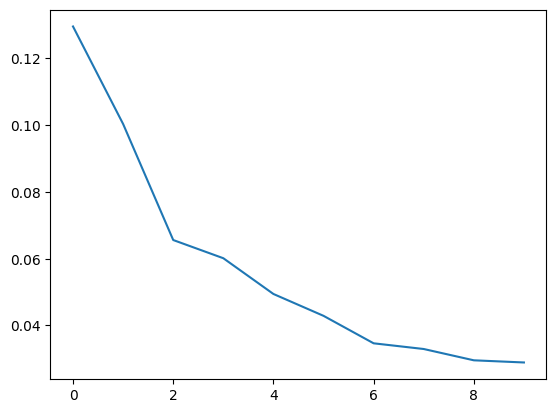

In [18]:
# plot variance explained
plt.plot(pca.explained_variance_ratio_)

In [55]:
# Remove mutant 53 for being an outlier
pca_df = pca_df[pca_df.mutant_id != 53]

In [56]:
pca_df

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,mutant_id,replica,profile
0,-1.107784,0.094149,2.435388,-1.735720,1.663918,-2.330085,0.866963,2.005581,1.188052,-1.121643,33,4,0
1,-1.092061,0.190507,2.300196,-1.352006,0.411249,-2.711315,1.005252,1.216183,0.725868,-1.295964,33,5,0
2,-0.957086,-0.280381,2.402792,-1.311943,1.287905,-2.683032,1.000867,2.502417,0.479682,-1.171814,33,6,0
3,-0.912481,-0.176572,2.336250,-1.048041,1.351530,-2.189533,1.051536,2.858353,0.510165,-1.361662,33,7,0
4,-1.090275,0.530470,2.283275,-1.283924,0.914101,-2.236089,0.578081,1.259556,0.272289,-1.051224,33,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,-0.098803,-2.475847,-1.806365,0.099981,2.701722,1.346366,-0.869468,-0.747431,-1.098721,-0.510869,wt,4,0
171,-0.519440,-2.436222,-2.047464,0.820697,2.377985,0.101642,-0.603616,-0.922314,-0.363029,-0.487550,wt,5,0
172,-0.138107,-2.171293,-1.920691,0.340661,2.491887,0.671670,-0.950545,-0.687840,-0.670643,0.168633,wt,6,0
173,-0.240469,-2.399095,-1.818152,0.092516,2.811755,1.322675,-0.815880,-0.910835,-0.926304,-0.455243,wt,7,0


In [57]:
components_df = pd.DataFrame(pca.components_)

In [58]:
components_df = components_df.abs().transpose()

In [59]:
components_df['contacts'] = contact_columns

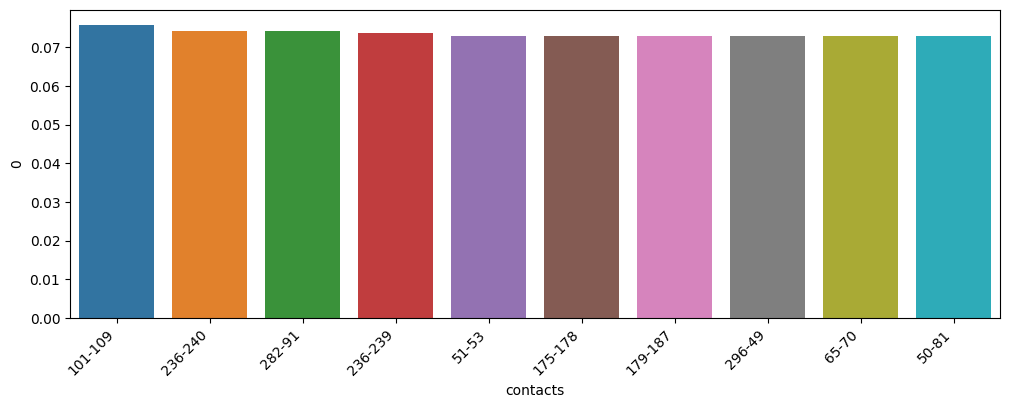

In [60]:
col = 0
components_df = components_df.sort_values(col, ascending=False)
plt.figure(figsize=(12,4))
sns.barplot(data=components_df.iloc[:10], x='contacts', y=col)
plt.xticks(rotation=45, ha='right')
plt.show()

In [61]:
col = 1
components_df = components_df.sort_values(col, ascending=False)
pc_df = components_df.iloc[:10][['contacts', col]]

pc_df[col] = pc_df[col].abs()
pc_df[col] = (pc_df[col] - pc_df[col].min()) / (pc_df[col].max() - pc_df[col].min()) + 1

bw_list = []

for c in pc_df.contacts:
    bw_pair = []
    for res in c.split('-'):
                
        res = clean_bw_dict.get(res, res)
            
        bw_pair.append(res)
    
    bw_list.append('-'.join(map(str, bw_pair)))
    
pc_df['bw'] = bw_list

pc_df['group'] = 1

In [62]:
pc_df

,contacts,1,bw,group
1091,131-240,2.000000,3.50-6.30,1
460,240-241,1.567477,6.30-6.31,1
1814,237-241,1.528885,237-6.31,1
1289,236-240,1.449688,236-6.30,1
250,127-131,1.417926,3.46-3.50,1
673,219-238,1.216680,5.68-6.28,1
512,142-146,1.149675,34.54-4.38,1
1377,124-247,1.029152,3.43-6.37,1
603,237-239,1.003293,237-6.29,1
1286,236-239,1.000000,236-6.29,1


In [63]:
# plot_contacts(pc_df, plot_motifs=True)

<Axes: ylabel='9'>

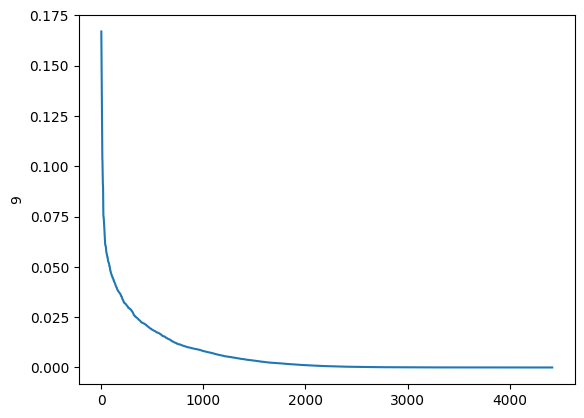

In [64]:
col = 9
components_df = components_df.sort_values(col, ascending=False)
sns.lineplot(data=components_df, x=np.arange(components_df.shape[0]), y=col)

In [65]:
np.cumsum(pca.explained_variance_ratio_)

array([0.12957066, 0.22992818, 0.29552721, 0.35567639, 0.40511473,
       0.44800491, 0.48266558, 0.51561856, 0.54518597, 0.57410385])

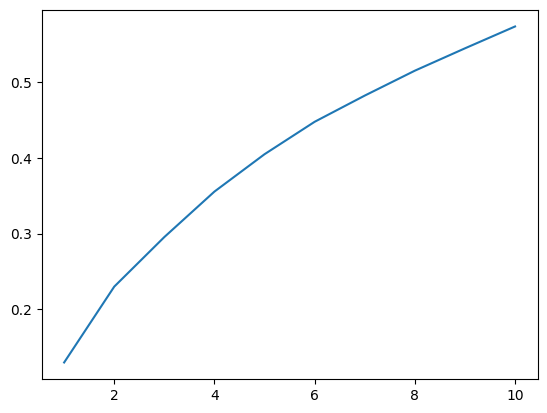

In [66]:
cum_exp_var = np.cumsum(pca.explained_variance_ratio_)

sns.lineplot(x=np.arange(1, 11), y=cum_exp_var)
plt.show()

# Explore different combinations of PCs

In [68]:
import plotly.express as px

In [69]:
pca_df

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,mutant_id,replica,profile
0,-1.107784,0.094149,2.435388,-1.735720,1.663918,-2.330085,0.866963,2.005581,1.188052,-1.121643,33,4,0
1,-1.092061,0.190507,2.300196,-1.352006,0.411249,-2.711315,1.005252,1.216183,0.725868,-1.295964,33,5,0
2,-0.957086,-0.280381,2.402792,-1.311943,1.287905,-2.683032,1.000867,2.502417,0.479682,-1.171814,33,6,0
3,-0.912481,-0.176572,2.336250,-1.048041,1.351530,-2.189533,1.051536,2.858353,0.510165,-1.361662,33,7,0
4,-1.090275,0.530470,2.283275,-1.283924,0.914101,-2.236089,0.578081,1.259556,0.272289,-1.051224,33,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,-0.098803,-2.475847,-1.806365,0.099981,2.701722,1.346366,-0.869468,-0.747431,-1.098721,-0.510869,wt,4,0
171,-0.519440,-2.436222,-2.047464,0.820697,2.377985,0.101642,-0.603616,-0.922314,-0.363029,-0.487550,wt,5,0
172,-0.138107,-2.171293,-1.920691,0.340661,2.491887,0.671670,-0.950545,-0.687840,-0.670643,0.168633,wt,6,0
173,-0.240469,-2.399095,-1.818152,0.092516,2.811755,1.322675,-0.815880,-0.910835,-0.926304,-0.455243,wt,7,0


In [70]:
# fig = px.scatter(pca_df, x="pc1", y="pc10", color=pca_df.profile.astype(str), hover_data=['mutant_id', 'replica'])
# fig.show()

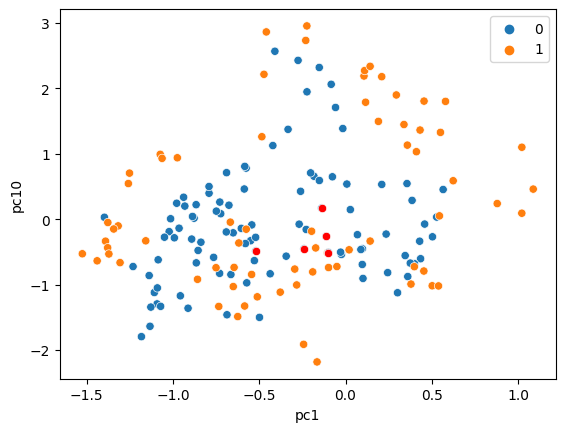

In [71]:
sns.scatterplot(data=pca_df, x='pc1', y='pc10', hue='profile')
sns.scatterplot(data=pca_df[pca_df.mutant_id == 'wt'], x='pc1', y='pc10', color='red')

plt.show()

In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [73]:
def plot_decission_surface(f1, f2, y, C=1):
    # fit logistic regression model
    clf = SVC(class_weight='balanced', C=C)
    # clf = RandomForestClassifier(max_depth=4)
    # clf = DecisionTreeClassifier(max_depth=4)
    clf.fit(np.stack([f1, f2]).transpose(), y)
    
    score = clf.score(np.stack([f1, f2]).transpose(), y)

    # define meshgrid of points to evaluate decision boundary
    x_min, x_max = f1.min() - 0.5, f1.max() + 0.5
    y_min, y_max = f2.min() - 0.5, f2.max() + 0.5
    h = 0.01  # step size in meshgrid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape).astype(int)

    # plot decision boundary and scatterplot of data points
    colors = sns.color_palette()
    plt.contourf(xx, yy, Z, alpha=0.4, colors=colors, )  # fill decision areas with color
    sns.scatterplot(x=f1, y=f2, hue=y)
    
    
    return score


0.8470588235294118

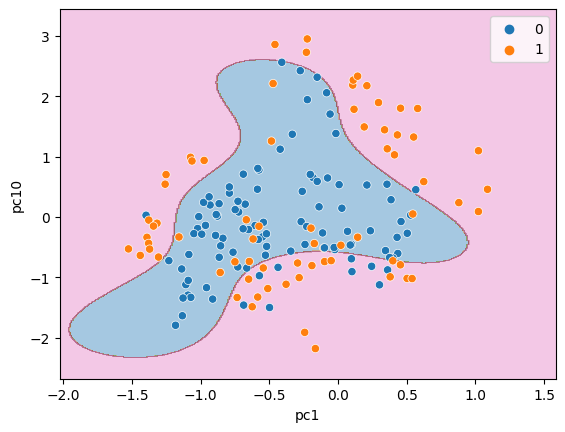

In [76]:
plot_decission_surface(pca_df["pc1"], pca_df["pc10"], pca_df['profile'].values, C=10)

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: xlabel='pc1', ylabel='pc10'>

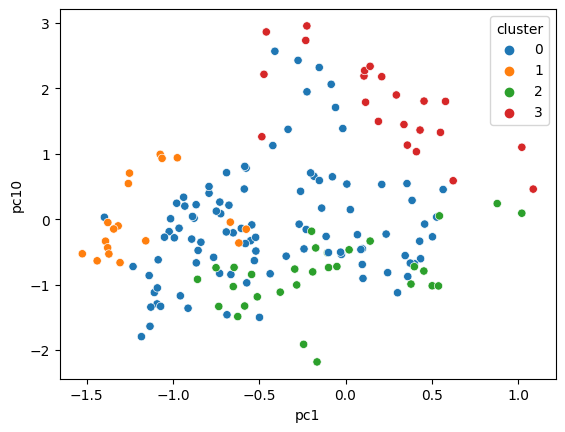

In [82]:
# perform a clustering of the profile 1 mutants using the PCs 1 and 10
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3).fit(pca_df[pca_df.profile == 1][['pc1', 'pc10']])
kmeans.labels_

pca_df['cluster'] = 0
pca_df.loc[pca_df.profile == 1, 'cluster'] = kmeans.labels_ + 1

# make cluster a categorical variable
pca_df.cluster = pca_df.cluster.astype('category')

# plot the scatterplot coloring by cluster
sns.scatterplot(data=pca_df, x='pc1', y='pc10', hue='cluster')

pc1 vs pc2


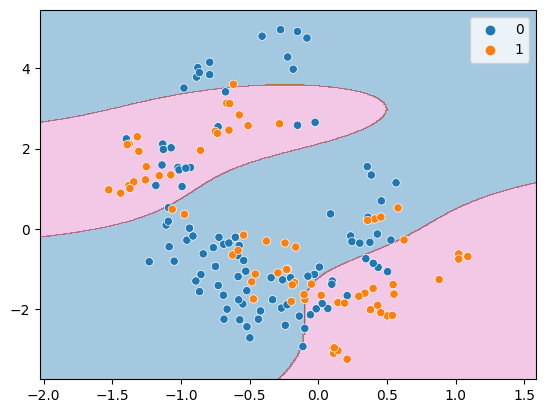

0.6823529411764706
pc1 vs pc3


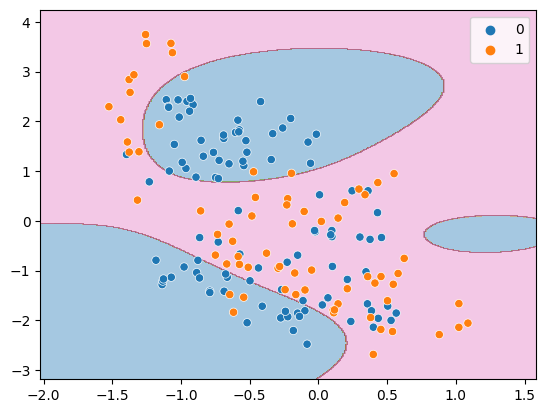

0.7411764705882353
pc1 vs pc4


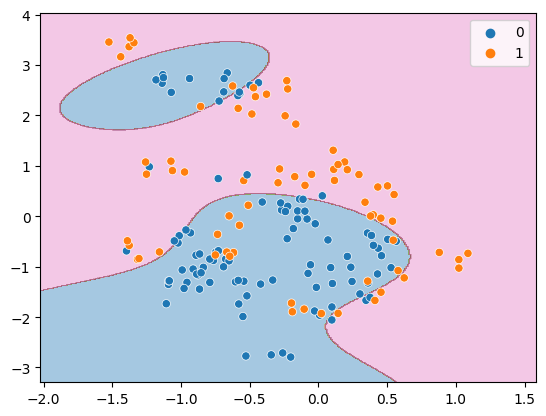

0.8117647058823529
pc1 vs pc5


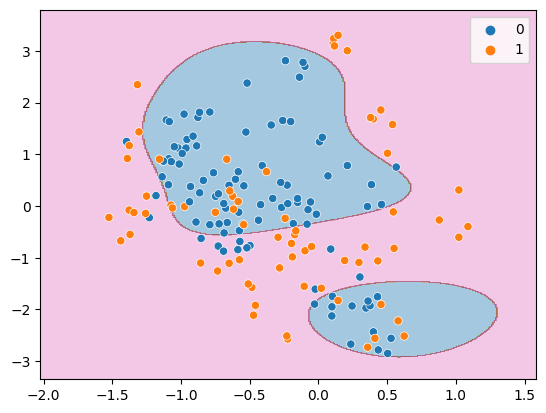

0.8058823529411765
pc1 vs pc6


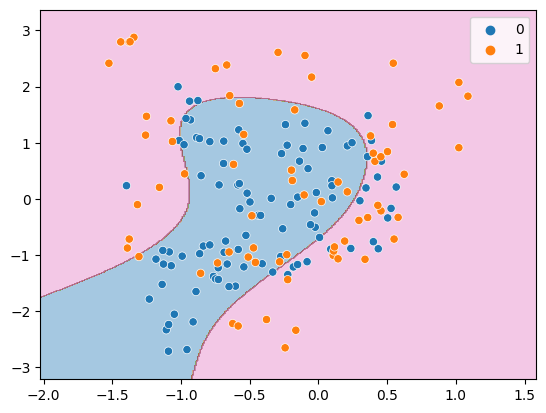

0.7411764705882353
pc1 vs pc7


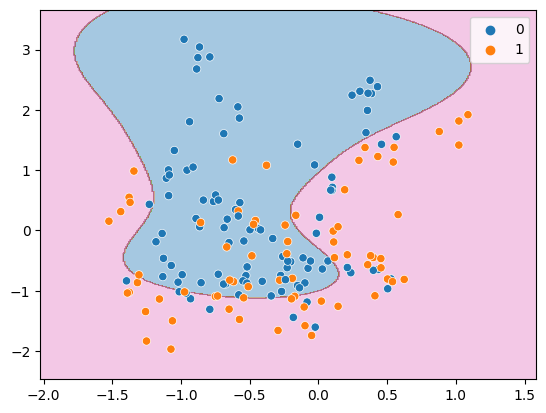

0.7647058823529411
pc1 vs pc8


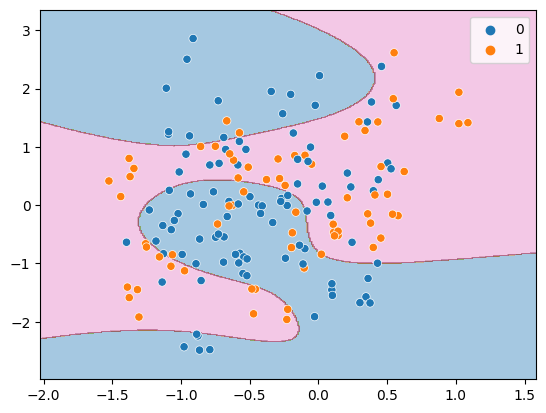

0.7294117647058823
pc1 vs pc9


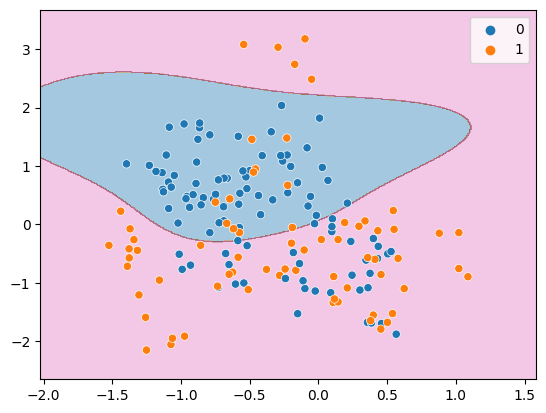

0.7176470588235294
pc1 vs pc10


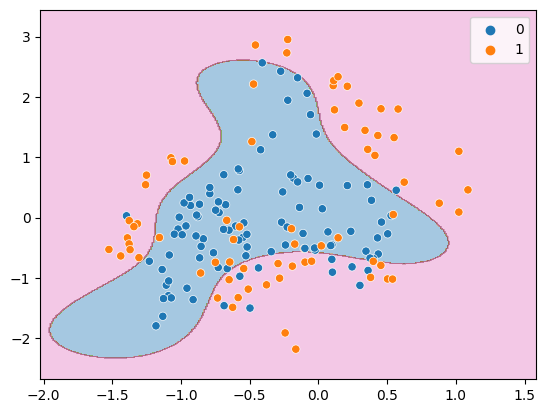

0.8470588235294118
pc2 vs pc1


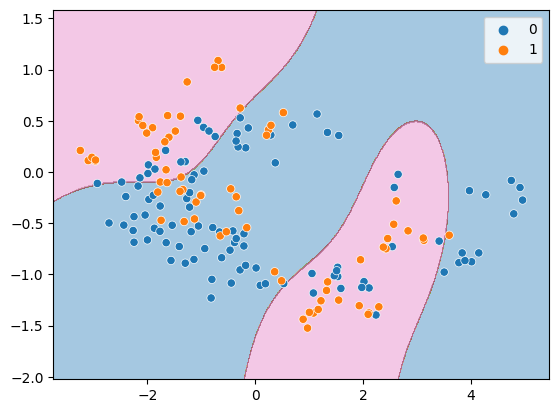

0.6823529411764706
pc2 vs pc3


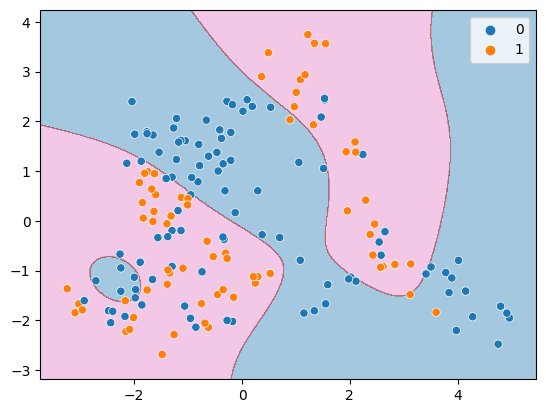

0.7764705882352941
pc2 vs pc4


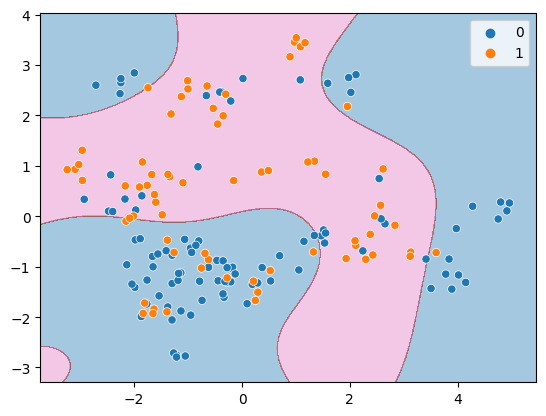

0.7470588235294118
pc2 vs pc5


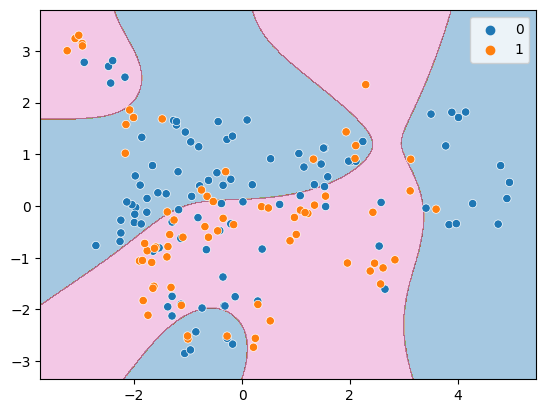

0.6941176470588235
pc2 vs pc6


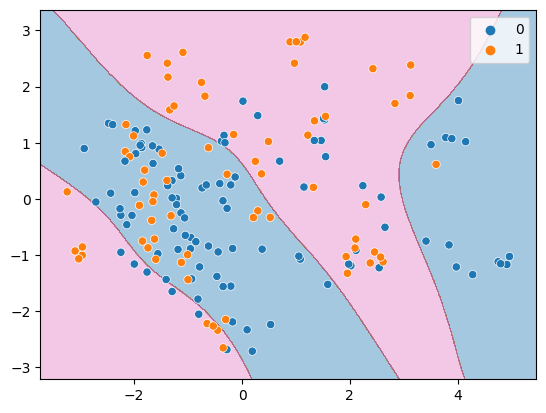

0.6882352941176471
pc2 vs pc7


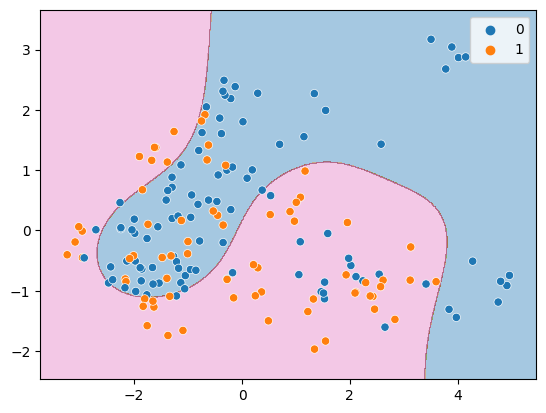

0.7529411764705882
pc2 vs pc8


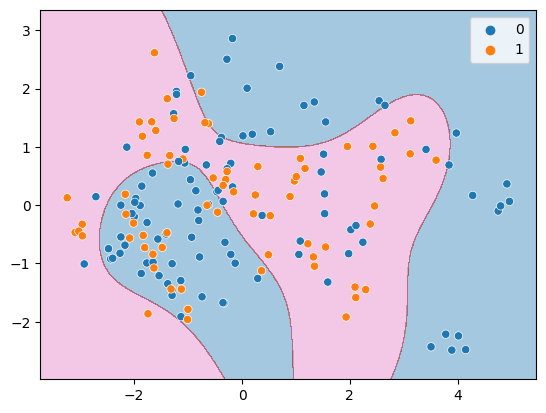

0.7058823529411765
pc2 vs pc9


KeyboardInterrupt: 

In [75]:
y = pca_df['profile'].values
scores = []
for i in range(1,11):
    for j in range(1,11):
        if i == j:
            continue
        
        c1 = f"pc{i}"
        c2 = f"pc{j}"
        
        f1 = pca_df[c1].values
        f2 = pca_df[c2].values

        
        print(f"{c1} vs {c2}")
        score = plot_decission_surface(f1, f2, y, C=10)
        # if 'pc1' in [c1, c2]:
        #     plt.xlim((-2, 2))
        plt.show()
        print(score)
        scores.append([c1, c2, score])

In [138]:
pd.DataFrame(scores).sort_values(2)

,0,1,2
0,pc1,pc2,0.682353
9,pc2,pc1,0.682353
13,pc2,pc6,0.688235
46,pc6,pc2,0.688235
37,pc5,pc2,0.694118
...,...,...,...
2,pc1,pc4,0.811765
84,pc10,pc4,0.811765
27,pc4,pc1,0.811765
8,pc1,pc10,0.847059


# Bias Cluster characterization

In [1]:
import os
os.chdir('/home/adri/Projects/phd/bias_2')

import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import MDAnalysis as mda
# import nglview as nv
import sys
sys.path.append('src/utils')
from get_BW_nomenclature import get_bw

import re
from sklearn.svm import SVC

In [20]:
groups = {2: ['117-1', '117-4', '217-7', '117-2', '217-6', '117-5', '117-3', '217-4', '217-5', '77-7', '77-8', '217-8', '77-4', '77-6', '77-5'],
          3: ['302-5', '302-3', '291-4', '291-8', '205-6', '302-4', '291-5', '205-8', '302-1', '291-7', '199-5', '291-6', '205-4', '205-7'],
          1: ['176-1', '176-5', '176-4', '292-1', '292-2', '292-5', '292-4', '285-4', '285-5', '292-3', '285-1', '125-5', '125-1', '285-3', '125-3', '285-2', '125-2', '125-4', '109-4', '109-2', '109-6', '109-3']}

In [24]:
catched_mutants = []
for cluster in groups:
    print(cluster)
    cluster_mutants = set([sim.split('-')[0] for sim in groups[cluster]])
    print(' '.join(cluster_mutants))
    catched_mutants.extend(cluster_mutants)



2
77 117 217
3
205 302 199 291
1
176 285 109 125 292


In [34]:
all_biased_mutants  = set([str(m) for m in profile_simulated_mutants])

In [36]:
len(set(all_biased_mutants))

14

In [37]:
set(all_biased_mutants) - set(catched_mutants)

{'297', '61'}

In [17]:
group_df = []
for label, sim_list in groups.items():
    for sim in sim_list:
        sys, rep  = sim.split('-')
        
        group_df.append([label, sys, rep])
group_df = pd.DataFrame(group_df, columns=['group', 'system', 'replica'])
group_df.to_csv('pca_groups.csv', index=False)

In [18]:
labels = []
for mid, rep, pro in df[['mutant_id', 'replica', 'profile']].values:
    
    # print(mid, rep, pro)
    
    if pro == 0:
        labels.append(pro)
        continue
    
    m1 = group_df.replica == str(rep)
    m2 = group_df.system == str(mid)
    
    gs = group_df[m1 & m2].group
    
    if gs.size > 0:
        g = gs.iloc[0]
        labels.append(g)
        
    else:
        labels.append(-1)
    

In [19]:
pd.Series(labels).value_counts()

 0    105
 1     22
-1     19
 2     15
 3     14
Name: count, dtype: int64

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
df

,mutant_id,replica,242-246,116-119,166-170,215-240,34-38,127-73,124-205,23-271,...,207-227,16-26,16-33,17-26,16-30,133-226,287-39,285-291,130-135,profile
3,33,4,1.000,0.380,1.000,0.000,0.988,0.000,0.297,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
4,33,5,1.000,0.565,0.995,0.000,1.000,0.000,0.405,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
5,33,6,1.000,0.463,0.993,0.005,0.995,0.000,0.297,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
6,33,7,1.000,0.472,1.000,0.000,0.990,0.018,0.325,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
7,33,8,1.000,0.510,0.993,0.260,0.998,0.003,0.305,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,wt,4,0.993,0.537,0.998,0.000,1.000,0.472,0.357,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.003,0.003,0.000,0
249,wt,5,1.000,0.463,0.985,0.000,1.000,0.265,0.378,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
250,wt,6,1.000,0.545,1.000,0.138,1.000,0.520,0.325,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
251,wt,7,1.000,0.568,0.990,0.000,1.000,0.347,0.325,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0


In [22]:
c_df = df[contact_columns]

In [23]:
u = mda.Universe('data/interim/aligned_sims/WT/structure.psf','data/interim/wt.pdb')
core = u.select_atoms('protein and name CA  and (prop z > 80) and (prop z < 120)')

In [24]:
core_resids = [str(resid) for resid in core.atoms.resids]

In [25]:
var_c_df = c_df.loc[:, (c_df.std() > 0.01).values.flatten()]

<Axes: ylabel='Count'>

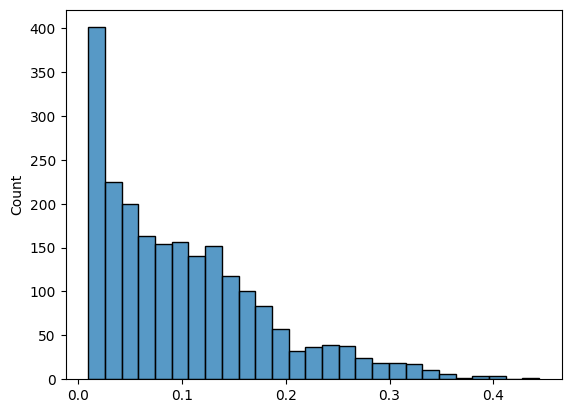

In [26]:
sns.histplot(var_c_df.std())

In [27]:
core_var_contacts = []
for col in var_c_df.columns:
    if len(set(col.split('-')) & set(core_resids)) == 2:
        core_var_contacts.append(col)
        

In [28]:
core_var_c_df = var_c_df[core_var_contacts]

In [29]:
corr_mat = core_var_c_df.corr()

In [30]:
def get_vmd_script(group, n):
    pass
    

In [31]:
micro_switch_dict = {'dry': range(130, 133),
                'npxxy': range(295, 300),
                'cwp': range(257, 261),
                'pif': [121, 201, 254],
                'sod_bs': [80, 120, 291, 292],
                'toogle_s': [258],
                '6.30': [240]}

In [32]:
r_micro_switch_dict = {}

for key, val in micro_switch_dict.items():
    for v in val:
        r_micro_switch_dict[v] = key

In [33]:
group = 1
n = 20

In [34]:
np.unique(labels, return_counts=True)

(array([-1,  0,  1,  2,  3]), array([ 19, 105,  22,  15,  14]))

In [35]:
mask = [l in [0, group] for l in labels]
X = core_var_c_df[mask]
y = np.array(labels)[mask]

clf = LogisticRegression(class_weight='balanced')
clf.fit(X, y)
clf.score(X, y)
coef = clf.coef_
coef_df = pd.DataFrame({'coef': coef.flatten(), 'feature': core_var_c_df.columns})
coef_df['abs_coef'] = coef_df.coef.abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False)
bw_list = []

for c in coef_df.feature:
    bw_pair = []
    for res in c.split('-'):
                
        res = clean_bw_dict.get(res, res)
            
        bw_pair.append(res)
    
    bw_list.append('-'.join(map(str, bw_pair)))
    
coef_df['bw'] = bw_list

# coef_df = coef_df[['feature', 'abs_coef', 'bw', 'group']]
coef_df = coef_df[:n]

coef_df.abs_coef = (coef_df.abs_coef - coef_df.abs_coef.min()) / (coef_df.abs_coef.max() - coef_df.abs_coef.min()) + 1

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
for feature in coef_df.feature:
    r1, r2 = feature.split('-')

In [37]:
coef_df

,coef,feature,abs_coef,bw
535,-0.887232,109-93,2.000000,3.28-2.63
379,-0.693047,180-25,1.622179,180-25
944,0.689460,25-94,1.615199,25-2.64
933,0.621747,26-95,1.483451,26-2.65
1154,0.549922,127-209,1.343703,3.46-5.58
485,-0.543416,93-96,1.331044,2.63-2.66
992,0.537708,25-281,1.319939,25-7.35
959,0.534578,128-209,1.313848,3.47-5.58
132,-0.533696,132-212,1.312133,3.51-5.61
209,-0.533280,172-189,1.311323,172-5.38


In [38]:
def plot_cluster_features(group, n=10):
    
    mask = [l in [0, group] for l in labels]
    X = core_var_c_df[mask]
    y = np.array(labels)[mask]

    clf = LogisticRegression(class_weight='balanced')
    clf.fit(X, y)
    clf.score(X, y)
    coef = clf.coef_
    coef_df = pd.DataFrame({'coef': coef.flatten(), 'feature': core_var_c_df.columns})
    coef_df['abs_coef'] = coef_df.coef.abs()
    coef_df = coef_df.sort_values('abs_coef', ascending=False)
    bw_list = []

    for c in coef_df.feature:
        bw_pair = []
        for res in c.split('-'):
                    
            res = clean_bw_dict.get(res, res)
                
            bw_pair.append(res)
        
        bw_list.append('-'.join(map(str, bw_pair)))
        
    coef_df['bw'] = bw_list

    coef_df['group'] = 1
    coef_df = coef_df[['feature', 'abs_coef', 'bw', 'group']]
    coef_df = coef_df[:n]
    
    coef_df.abs_coef = (coef_df.abs_coef - coef_df.abs_coef.min()) / (coef_df.abs_coef.max() - coef_df.abs_coef.min()) + 1
    w = plot_contacts(coef_df)
    return w

In [39]:
def get_ms_contacts(group, n):
    
    mask = [l in [0, group] for l in labels]
    X = core_var_c_df[mask]
    y = np.array(labels)[mask]

    clf = LogisticRegression(class_weight='balanced', max_iter=500)
    clf.fit(X, y)
    clf.score(X, y)
    coef = clf.coef_
    coef_df = pd.DataFrame({'coef': coef.flatten(), 'feature': core_var_c_df.columns})
    coef_df['abs_coef'] = coef_df.coef.abs()
    coef_df = coef_df.sort_values('abs_coef', ascending=False)
    bw_list = []

    for c in coef_df.feature:
        bw_pair = []
        for res in c.split('-'):
                    
            res = clean_bw_dict.get(res, res)
                
            bw_pair.append(res)
        
        bw_list.append('-'.join(map(str, bw_pair)))
        
    coef_df['bw'] = bw_list

    coef_df['group'] = group
    coef_df = coef_df[['feature', 'coef', 'abs_coef', 'bw', 'group']]
    coef_df = coef_df[:n]
    
    ms_labels = []
    
    for feature in coef_df.feature:
        
        r1, r2 = [int(x) for  x in feature.split('-')]
        # print(r1, r2)
        ms1 = r_micro_switch_dict.get(r1)
        ms2 = r_micro_switch_dict.get(r2)
        
        ms_list = list(set([ms1, ms2]) - set([None]))
        if not ms_list:
            ms_list = [None]
            
        # print(ms_list[0])
        
        ms_labels.append(ms_list[0])
        
    coef_df['micro_switch'] = ms_labels
    
    # coef_df = coef_df[coef_df.micro_switch.astype(bool)]

    return coef_df

In [40]:
all_coef_df = []
for group in range(1, 4):
    coef_df = get_ms_contacts(group,20)

    all_coef_df.append(coef_df)
    
all_coef_df = pd.concat(all_coef_df)
all_coef_df

,feature,coef,abs_coef,bw,group,micro_switch
535,109-93,-0.887910,0.887910,3.28-2.63,1,None
379,180-25,-0.693003,0.693003,180-25,1,None
944,25-94,0.689761,0.689761,25-2.64,1,None
933,26-95,0.621155,0.621155,26-2.65,1,None
1154,127-209,0.550139,0.550139,3.46-5.58,1,None
485,93-96,-0.543324,0.543324,2.63-2.66,1,None
992,25-281,0.538605,0.538605,25-7.35,1,None
959,128-209,0.534744,0.534744,3.47-5.58,1,None
132,132-212,-0.534611,0.534611,3.51-5.61,1,dry
209,172-189,-0.533454,0.533454,172-5.38,1,None


In [41]:
all_coef_df.to_csv('results/clustering/ms_connections.csv')

In [43]:
micro_switch_dict

{'dry': range(130, 133),
 'npxxy': range(295, 300),
 'cwp': range(257, 261),
 'pif': [121, 201, 254],
 'sod_bs': [80, 120, 291, 292],
 'toogle_s': [258],
 '6.30': [240]}

In [44]:
ms_residues = []
for ms in micro_switch_dict.values():
    ms_residues.extend(ms)

In [52]:
# Get the list atoms not belonging to ms

non_ms_resids = {}
for g in all_coef_df.group.unique():

    non_ms_resids[g] = []

    group_df = all_coef_df[all_coef_df.group == g]

    for feature in group_df.feature:
        r1, r2 = feature.split('-')

        for r in [r1, r2]:

            if int(r) not in ms_residues:
                non_ms_resids[g].append(r)


In [53]:
for g, residues in non_ms_resids.items():
    print(g)
    print(' '.join(residues))  

1
109 93 180 25 25 94 26 95 127 209 93 96 25 281 128 209 212 172 189 136 140 65 71 195 87 90 125 204 109 94 25 26 212 209 248
2
109 93 244 247 37 96 289 40 288 87 34 35 288 26 95 285 87 127 285 91 124 247 67 71 40 87 47 25 27 65 71 92 95 127 69
3
33 96 92 95 93 95 182 25 26 95 25 278 209 247 245 302 282 286 44 84 127 31 35 27 281 113 87 246 267 277 51 91 96 281 285


In [42]:
all_coef_df

,feature,coef,abs_coef,bw,group,micro_switch
535,109-93,-0.887910,0.887910,3.28-2.63,1,None
379,180-25,-0.693003,0.693003,180-25,1,None
944,25-94,0.689761,0.689761,25-2.64,1,None
933,26-95,0.621155,0.621155,26-2.65,1,None
1154,127-209,0.550139,0.550139,3.46-5.58,1,None
485,93-96,-0.543324,0.543324,2.63-2.66,1,None
992,25-281,0.538605,0.538605,25-7.35,1,None
959,128-209,0.534744,0.534744,3.47-5.58,1,None
132,132-212,-0.534611,0.534611,3.51-5.61,1,dry
209,172-189,-0.533454,0.533454,172-5.38,1,None
